In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [ ]:
%pip install mlflow dagshub

In [2]:
import dagshub
dagshub.init(repo_owner='prathamshelke2903', repo_name='Swiggy_Delivery_Time_Prediction', mlflow=True)

Accessing as prathamshelke2903

Initialized MLflow to track repo "prathamshelke2903/Swiggy_Delivery_Time_Prediction"

Repository prathamshelke2903/Swiggy_Delivery_Time_Prediction initialized!

In [3]:
import mlflow

In [4]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow")

In [5]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - LGBM HP Tuning")

2025/06/28 18:31:47 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - LGBM HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/7e0b5f338c7f4d499598d92896a56d17', creation_time=1751115707803, experiment_id='3', last_update_time=1751115707803, lifecycle_stage='active', name='Exp 4 - LGBM HP Tuning', tags={}>

In [6]:
from sklearn import set_config

set_config(transform_output="pandas")

# Loading Cleaned Data

In [7]:
# load the cleaned data

df = pd.read_csv('/Users/prathamshelke/Desktop/EndToEndProjects/Swiggy_Delivery_Time_Prediction/swiggy_dataset/swiggy_cleaned.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [8]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [9]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [10]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [11]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

<Axes: >

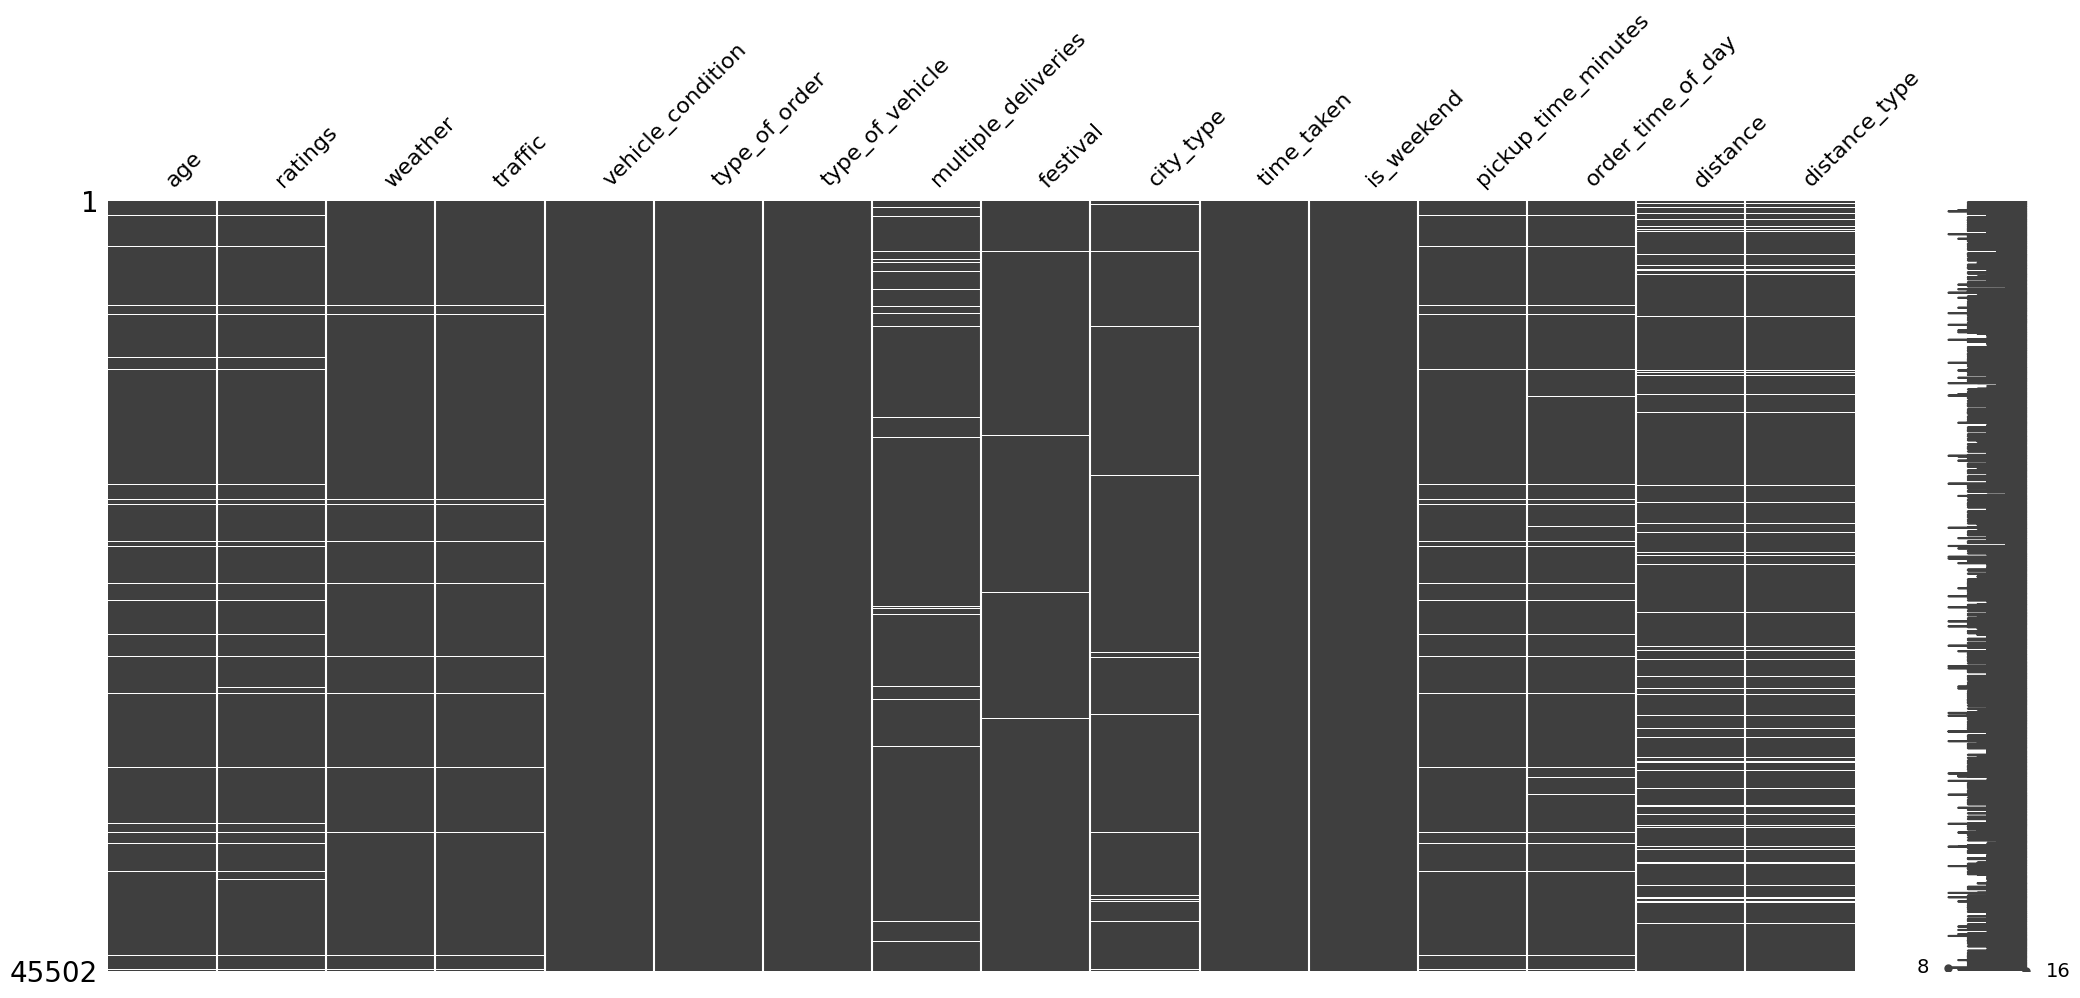

In [12]:
import missingno as msno

msno.matrix(df)

In [13]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [14]:
temp_df = df.copy().dropna()

In [15]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [16]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [18]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [19]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [20]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [21]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(0.0)

# Pre-Processing Pipeline

In [22]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [23]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [24]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [25]:
# # features to fill values with mode

# features_to_fill_mode = ['multiple_deliveries','festival','city_type']
# features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

# features_to_fill_missing

In [26]:
# # simple imputer to fill categorical vars with mode

# simple_imputer = ColumnTransformer(transformers=[
#     ("mode_imputer",SimpleImputer(strategy="most_frequent",add_indicator=True),features_to_fill_mode),
#     ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing",add_indicator=True),features_to_fill_missing)
# ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

# simple_imputer

In [27]:
# simple_imputer.fit_transform(X_train)

In [28]:
# simple_imputer.fit_transform(X_train).isna().sum()

In [29]:
# knn imputer

# knn_imputer = KNNImputer(n_neighbors=5)

In [30]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [31]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [32]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [33]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [34]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                # ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor)
                                # ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

,steps,"[('preprocess', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [35]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


In [36]:
X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8708,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25198,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34049,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
25987,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37121,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7590,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13610,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [37]:
%pip install optuna


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
from lightgbm import LGBMRegressor
import optuna

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [40]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        xgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=xgb_reg,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())
        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [41]:
# create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score",study.best_value)

    # train the model on best parameters
    best_lgbm = LGBMRegressor(**study.best_params)

    best_lgbm.fit(X_train_trans,y_train_pt.values.ravel())

    # get the predictions
    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    # get the actual predictions values
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


    # perform cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm,
                                        transformer=pt)


    scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",- scores.mean())

    # log the best model
    mlflow.sklearn.log_model(best_lgbm,artifact_path="model")

[I 2025-06-28 18:31:51,080] A new study created in memory with name: no-name-38749f59-09aa-4ff4-907e-0bb7cd2c8d1a
  0%|                                                                     | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training be

Best trial: 8. Best value: 3.71604:   2%|▌                        | 1/50 [00:50<41:33, 50.90s/it]

[I 2025-06-28 18:32:42,534] Trial 8 finished with value: 3.7160440402898636 and parameters: {'n_estimators': 82, 'max_depth': 37, 'learning_rate': 0.7925907036846936, 'subsample': 0.9297359134714521, 'min_child_weight': 5, 'min_split_gain': 5.6572611290501085, 'reg_lambda': 62.420835389295824}. Best is trial 8 with value: 3.7160440402898636.


Best trial: 8. Best value: 3.71604:   4%|█                        | 2/50 [00:51<17:15, 21.56s/it]

[I 2025-06-28 18:32:43,566] Trial 2 finished with value: 3.720944479096496 and parameters: {'n_estimators': 33, 'max_depth': 37, 'learning_rate': 0.42265185113806275, 'subsample': 0.7234592067883201, 'min_child_weight': 12, 'min_split_gain': 6.0477299871904835, 'reg_lambda': 10.706545511822728}. Best is trial 8 with value: 3.7160440402898636.


Best trial: 6. Best value: 3.52518:   6%|█▌                       | 3/50 [00:52<09:31, 12.17s/it]

[I 2025-06-28 18:32:44,556] Trial 6 finished with value: 3.5251829220822466 and parameters: {'n_estimators': 99, 'max_depth': 25, 'learning_rate': 0.1844114614744639, 'subsample': 0.8250859735176599, 'min_child_weight': 9, 'min_split_gain': 2.3035963423152506, 'reg_lambda': 83.32140079637452}. Best is trial 6 with value: 3.5251829220822466.


Best trial: 0. Best value: 3.47619:   8%|██                       | 4/50 [00:53<05:56,  7.75s/it]

[I 2025-06-28 18:32:45,531] Trial 0 finished with value: 3.4761872514786782 and parameters: {'n_estimators': 95, 'max_depth': 14, 'learning_rate': 0.38319311498969133, 'subsample': 0.5217311921451884, 'min_child_weight': 14, 'min_split_gain': 1.6642583038848113, 'reg_lambda': 10.037870293932949}. Best is trial 0 with value: 3.4761872514786782.


Best trial: 0. Best value: 3.47619:  10%|██▌                      | 5/50 [00:54<03:59,  5.32s/it]

[I 2025-06-28 18:32:46,540] Trial 9 finished with value: 3.803422904141052 and parameters: {'n_estimators': 28, 'max_depth': 3, 'learning_rate': 0.2098367241326631, 'subsample': 0.5088858149541984, 'min_child_weight': 16, 'min_split_gain': 1.9517960340959395, 'reg_lambda': 17.57355317100955}. Best is trial 0 with value: 3.4761872514786782.


Best trial: 0. Best value: 3.47619:  12%|███                      | 6/50 [00:55<02:49,  3.85s/it]

[I 2025-06-28 18:32:47,540] Trial 3 finished with value: 3.5436219013657095 and parameters: {'n_estimators': 67, 'max_depth': 4, 'learning_rate': 0.10753372982291272, 'subsample': 0.5358332399841974, 'min_child_weight': 20, 'min_split_gain': 0.23264835511862536, 'reg_lambda': 92.16564719955971}. Best is trial 0 with value: 3.4761872514786782.


Best trial: 0. Best value: 3.47619:  14%|███▌                     | 7/50 [00:56<02:05,  2.93s/it]

[I 2025-06-28 18:32:48,560] Trial 7 finished with value: 3.747052910689034 and parameters: {'n_estimators': 170, 'max_depth': 26, 'learning_rate': 0.26494830335020453, 'subsample': 0.5274916940454171, 'min_child_weight': 16, 'min_split_gain': 9.062200624999369, 'reg_lambda': 37.955864273892445}. Best is trial 0 with value: 3.4761872514786782.


Best trial: 0. Best value: 3.47619:  16%|████                     | 8/50 [00:57<01:36,  2.31s/it]

[I 2025-06-28 18:32:49,550] Trial 5 finished with value: 3.683520458231251 and parameters: {'n_estimators': 57, 'max_depth': 12, 'learning_rate': 0.6222706778758883, 'subsample': 0.8082009786671907, 'min_child_weight': 9, 'min_split_gain': 3.230843650171579, 'reg_lambda': 19.951443560564208}. Best is trial 0 with value: 3.4761872514786782.


Best trial: 0. Best value: 3.47619:  18%|████▌                    | 9/50 [00:58<01:18,  1.92s/it]

[I 2025-06-28 18:32:50,625] Trial 1 finished with value: 3.7837598766673537 and parameters: {'n_estimators': 86, 'max_depth': 30, 'learning_rate': 0.5191510293070277, 'subsample': 0.8891425963030433, 'min_child_weight': 13, 'min_split_gain': 8.12488831206954, 'reg_lambda': 13.045725732679214}. Best is trial 0 with value: 3.4761872514786782.


Best trial: 4. Best value: 3.46945:  20%|████▊                   | 10/50 [00:59<01:04,  1.62s/it]

[I 2025-06-28 18:32:51,557] Trial 4 finished with value: 3.469445808655955 and parameters: {'n_estimators': 100, 'max_depth': 37, 'learning_rate': 0.7139775309297027, 'subsample': 0.629872292568793, 'min_child_weight': 5, 'min_split_gain': 1.1285062819075364, 'reg_lambda': 0.8158936966365493}. Best is trial 4 with value: 3.469445808655955.

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warn

Best trial: 4. Best value: 3.46945:  20%|████▊                   | 10/50 [01:12<04:50,  7.27s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 24125, number of used features: 25
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

KeyboardInterrupt: 

[W 2025-06-28 18:33:24,616] Trial 11 failed with parameters: {'n_estimators': 149, 'max_depth': 40, 'learning_rate': 0.7239648413075385, 'subsample': 0.6614823311590523, 'min_child_weight': 6, 'min_split_gain': 4.197315657087686, 'reg_lambda': 40.4591104463114} because of the following error: BrokenProcessPool('A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.').
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py", line 453, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py", line 106, in get
    if not self._rlock.acquire(block, timeout):
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyboardInterrupt
"""

The above exception was th

🏃 View run flawless-ant-679 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3/runs/1aa521f92d49427c9ba8430535c1b7b3
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3
🏃 View run selective-bear-1 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3/runs/3dbfc7d64bf0408381d831b19922d98d
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3
🏃 View run zealous-snipe-822 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3/runs/7c8f182efa90415cb2d6dd8b1bb4488d
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3
🏃 View run auspicious-cat-211 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3/runs/23b1548164534247967f77717b08bba7


[I 2025-06-28 18:33:51,650] Trial 12 finished with value: 3.684621506049065 and parameters: {'n_estimators': 157, 'max_depth': 40, 'learning_rate': 0.7732726616203889, 'subsample': 0.6431851577673474, 'min_child_weight': 5, 'min_split_gain': 4.310733642420724, 'reg_lambda': 49.23398504641295}. Best is trial 4 with value: 3.469445808655955.
[I 2025-06-28 18:33:52,569] Trial 13 finished with value: 3.313631007245393 and parameters: {'n_estimators': 151, 'max_depth': 40, 'learning_rate': 0.7937150638538163, 'subsample': 0.6661984177913597, 'min_child_weight': 5, 'min_split_gain': 0.05540125122862327, 'reg_lambda': 41.88365976234361}. Best is trial 13 with value: 3.313631007245393.


🏃 View run fortunate-auk-530 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3/runs/91eaa215178f48529d698d9f834c1cb7
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/3


[I 2025-06-28 18:33:54,618] Trial 14 finished with value: 3.729330825735302 and parameters: {'n_estimators': 144, 'max_depth': 40, 'learning_rate': 0.7523071329859892, 'subsample': 0.6784567498195726, 'min_child_weight': 5, 'min_split_gain': 4.168141468859373, 'reg_lambda': 42.86714626979739}. Best is trial 13 with value: 3.313631007245393.
[I 2025-06-28 18:33:55,539] Trial 15 finished with value: 3.796632468895291 and parameters: {'n_estimators': 149, 'max_depth': 18, 'learning_rate': 0.7987428359647323, 'subsample': 0.6559053501660382, 'min_child_weight': 5, 'min_split_gain': 3.880146851432565, 'reg_lambda': 45.27028797212716}. Best is trial 13 with value: 3.313631007245393.
[I 2025-06-28 18:33:56,563] Trial 16 finished with value: 3.702533072801066 and parameters: {'n_estimators': 152, 'max_depth': 39, 'learning_rate': 0.7805203616146399, 'subsample': 0.6592489129257809, 'min_child_weight': 6, 'min_split_gain': 3.9349816587341753, 'reg_lambda': 45.435278021820075}. Best is trial 13 

In [42]:
study.best_params

{'n_estimators': 100,
 'max_depth': 37,
 'learning_rate': 0.7139775309297027,
 'subsample': 0.629872292568793,
 'min_child_weight': 5,
 'min_split_gain': 1.1285062819075364,
 'reg_lambda': 0.8158936966365493}

In [43]:
study.best_value

3.469445808655955

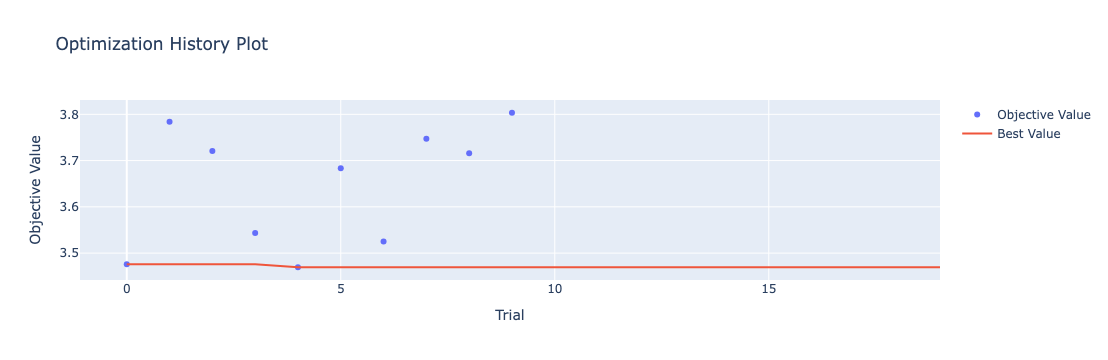

In [44]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

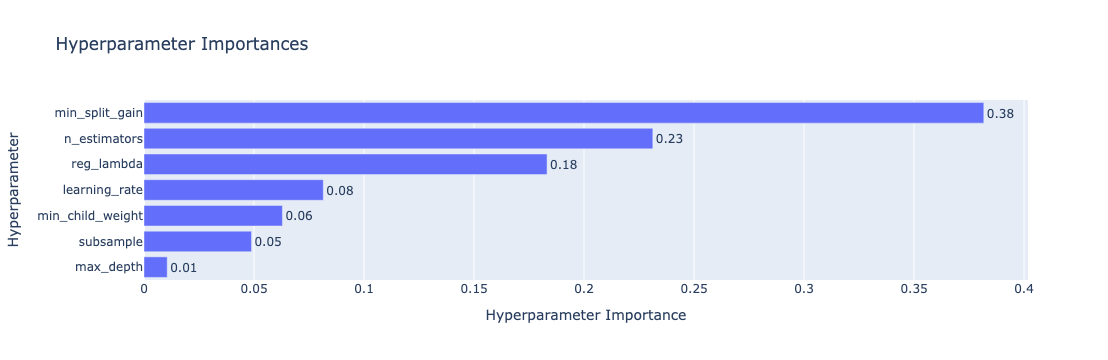

In [45]:
# plot hyperparameter importance plot

optuna.visualization.plot_param_importances(study)

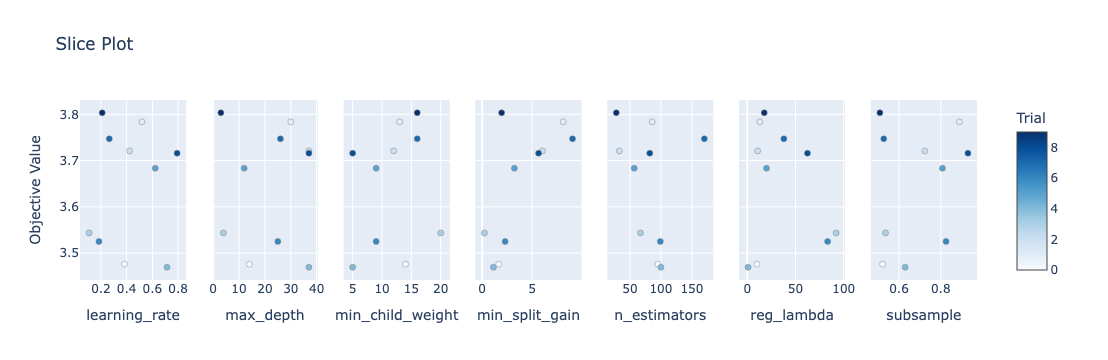

In [46]:
# slice plot

optuna.visualization.plot_slice(study)